In [3]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 10.7 MB/s eta 0:00:00


Unnamed: 0  CHỈ SỐ GIÁ TIÊU DÙNG  I, Hàng ăn và dịch vụ ăn uống  \
Tháng 01                   99.80                         100.28   
Tháng 02                   99.95                         100.53   
Tháng 03                  100.15                         100.36   
Tháng 04                  100.14                          99.58   
Tháng 05                  100.16                          99.78   

Unnamed: 0  II, Đồ uống và thuốc lá  III, May mặc, mũ nón, giầy dép  \
Tháng 01                     100.37                          100.51   
Tháng 02                     100.56                          100.45   
Tháng 03                      99.89                           99.96   
Tháng 04                      99.99                          100.14   
Tháng 05                     100.20                          100.14   

Unnamed: 0  IV, Nhà ở và vật liệu xây dựng (*)  \
Tháng 01                                 98.91   
Tháng 02                                 99.59   
Tháng 03            

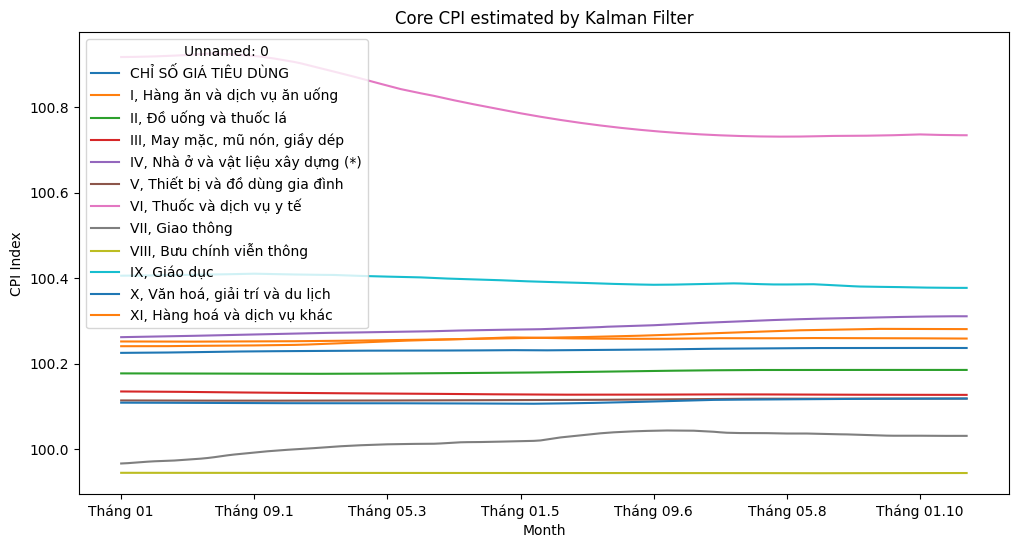

In [13]:
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Đọc dữ liệu (giả sử có cột đầu tiên là tên ngành)
df = pd.read_excel('cpi_data.xlsx')

# Bỏ cột đầu (tên ngành), giữ lại chỉ số CPI
sector_names = df.iloc[:, 0]
cpi_values = df.iloc[:, 1:].T  # chuyển tháng thành hàng
cpi_values.columns = sector_names

# Dữ liệu chuẩn bị xong: mỗi cột là 1 ngành, mỗi hàng là 1 tháng
print(cpi_values.head())

cpi_values.to_excel("cpi_values_t.xlsx")

# Hàm áp dụng Kalman Filter smoothing cho 1 chuỗi CPI
def kalman_smooth(series):
    # Mô hình đơn giản: trạng thái ẩn ~ giá trị thật, quan sát = trạng thái + nhiễu
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=series.iloc[0],
        observation_covariance=1,
        transition_covariance=1e-4
    )
    state_means, _ = kf.smooth(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

# Áp dụng cho từng ngành
smoothed = cpi_values.apply(kalman_smooth)

# Hiển thị kết quả
smoothed.plot(figsize=(12,6), title='Core CPI estimated by Kalman Filter')
plt.xlabel('Month')
plt.ylabel('CPI Index')
plt.show()

# Lưu ra file
smoothed.to_excel('core_cpi_kalman.xlsx')


In [14]:
total_cpi = smoothed['CHỈ SỐ GIÁ TIÊU DÙNG']
corr = smoothed.corrwith(total_cpi).sort_values(ascending=False)
print(corr)


Unnamed: 0
CHỈ SỐ GIÁ TIÊU DÙNG                  1.000000
IV, Nhà ở và vật liệu xây dựng (*)    0.982448
XI, Hàng hoá và dịch vụ khác          0.958066
V, Thiết bị và đồ dùng gia đình       0.934538
II, Đồ uống và thuốc lá               0.928735
VII, Giao thông                       0.887355
X, Văn hoá, giải trí và du lịch       0.847751
I, Hàng ăn và dịch vụ ăn uống         0.837904
III, May mặc, mũ nón, giầy dép       -0.880650
VIII, Bưu chính viễn thông           -0.892145
IX, Giáo dục                         -0.913197
VI, Thuốc và dịch vụ y tế            -0.919403
dtype: float64


In [15]:
import numpy as np

volatility = smoothed.std()
print(volatility.sort_values())  # Thấp nhất là ổn định nhất


Unnamed: 0
VIII, Bưu chính viễn thông            0.000235
V, Thiết bị và đồ dùng gia đình       0.001926
III, May mặc, mũ nón, giầy dép        0.002399
CHỈ SỐ GIÁ TIÊU DÙNG                  0.003408
II, Đồ uống và thuốc lá               0.003691
X, Văn hoá, giải trí và du lịch       0.004471
I, Hàng ăn và dịch vụ ăn uống         0.007296
XI, Hàng hoá và dịch vụ khác          0.010961
IX, Giáo dục                          0.010995
IV, Nhà ở và vật liệu xây dựng (*)    0.015697
VII, Giao thông                       0.022242
VI, Thuốc và dịch vụ y tế             0.074972
dtype: float64


In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(smoothed)
weights = pd.Series(np.abs(pca.components_[0]), index=smoothed.columns)
print(weights.sort_values(ascending=False))


Unnamed: 0
VI, Thuốc và dịch vụ y tế             0.924746
VII, Giao thông                       0.261431
IV, Nhà ở và vật liệu xây dựng (*)    0.177638
IX, Giáo dục                          0.130735
XI, Hàng hoá và dịch vụ khác          0.120577
I, Hàng ăn và dịch vụ ăn uống         0.085209
II, Đồ uống và thuốc lá               0.041691
X, Văn hoá, giải trí và du lịch       0.039367
CHỈ SỐ GIÁ TIÊU DÙNG                  0.039060
III, May mặc, mũ nón, giầy dép        0.027960
V, Thiết bị và đồ dùng gia đình       0.021219
VIII, Bưu chính viễn thông            0.002415
dtype: float64
